In [146]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
from collections import defaultdict
from sequencing_tools.viz_tools import okabeito_palette, \
                        simpsons_palette, \
                        RNA_base_from_picard, \
                        RNA_cov_from_picard, \
                        color_encoder
from sequencing_tools.stats_tools import normalize_count
from collections import defaultdict
import re
import glob
import os
from tgirt_map.table_tools import change_gene_type
from plotting_utils import label_sample, rename_sample, \
                        label_ce, rna_type_ce, \
                        figure_path
from count_plot import plot_insert, plot_coding_bases, plot_strand, plot_count, sample_wise_fraction

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# insert size

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


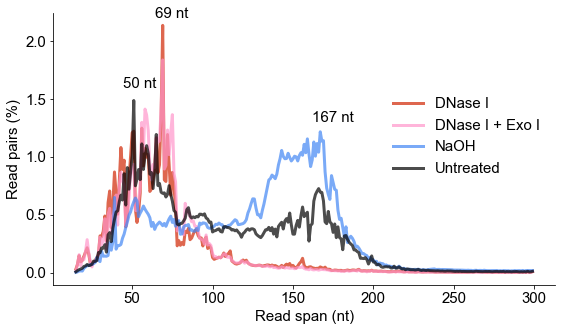

In [113]:
fig = plt.figure(figsize = (9,5))
ax_insert = fig.add_subplot(111)
idf = plot_insert(ax_insert, samples = ['DNase I', 'DNase I + Exo I',
                                       'NaOH', 'Untreated', 'Unfragmented'])#,
                                     # "DNase I - 3'P" ])
sns.despine()
#ax_insert.set_ylim(0,2)
ax_insert.text(64, 2.2, '69 nt', fontsize=15)
ax_insert.text(44, 1.6, '50 nt', fontsize=15)
ax_insert.text(162, 1.3, '167 nt', fontsize=15)

fig.savefig(figure_path + '/insert_plots.pdf', bbox_inches = 'tight')

In [114]:
idf.groupby('label').apply(lambda d: d[d.size_fraction==d.size_fraction.max()])

,,label,isize,size_fraction
label,,,,
DNase I,3751,DNase I,69,2.137538
DNase I + Exo I,623,DNase I + Exo I,69,1.838563
NaOH,152,NaOH,167,1.217203
Untreated,4018,Untreated,51,1.487837


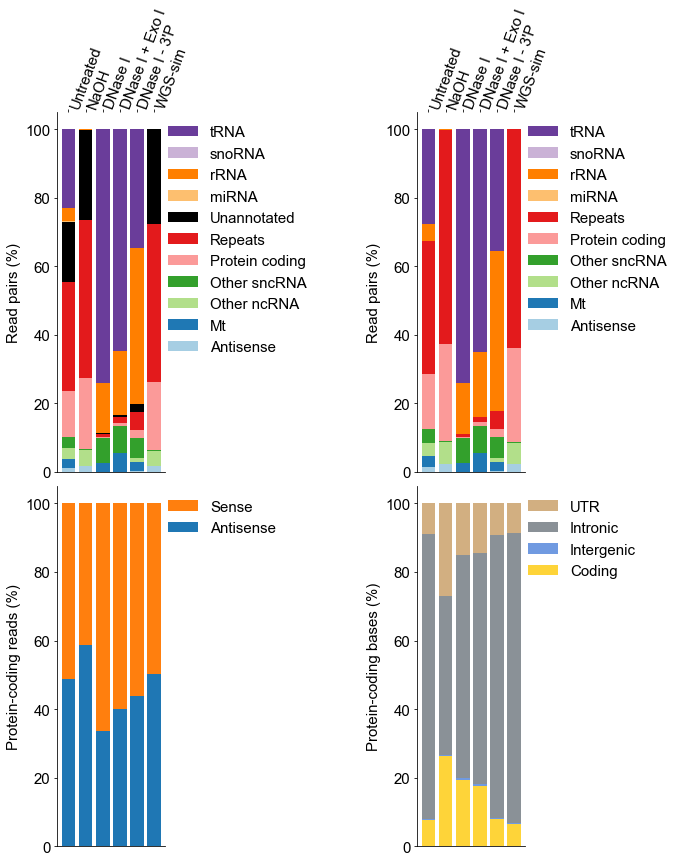

In [115]:
#fig = plt.figure(figsize = (10,8))
#ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
#ax_frag_dist_feature_only = fig.add_axes([0.5,0,0.15,0.5])
#ax_strand = fig.add_axes([1,0,0.15,0.5])
#ax_coding = fig.add_axes([1.4,0,0.15,0.5])

fig = plt.figure(figsize = (10,10))
ax_frag_dist = fig.add_axes([0,0.52,0.15,0.5])
ax_frag_dist_feature_only = fig.add_axes([0.5,0.52,0.15,0.5])
ax_strand = fig.add_axes([0,0,0.15,0.5])
ax_coding = fig.add_axes([0.5,0, 0.15, 0.5])


cdf = plot_count(ax_frag_dist, feature_only=False)
cdf = plot_count(ax_frag_dist_feature_only, feature_only=True)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)
ax_strand.xaxis.set_visible(False)
ax_coding.xaxis.set_visible(False)
ax_frag_dist.xaxis.tick_top()
ax_frag_dist_feature_only.xaxis.tick_top()
#fig.tight_layout()
fig.savefig(figure_path + '/fragment_plots.pdf', bbox_inches = 'tight')

In [156]:
from collections import defaultdict
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/all_counts.feather', nthreads=24) \
    .query('dedup == "dedup"')\
    .pipe(lambda d: d[d.samplename.str.contains('Qcf|EV|PF')]) \
    .assign(grouped_type = lambda d: d.gene_type.map(change_gene_type)) \
    .assign(prep = lambda d: d.samplename.map(label_sample))
dedup_df.head()

,samplename,strand,gene_type,gene_name,gene_id,dedup,read_count,grouped_type,prep
19035,MPCEV_R1_001,antisense,18S_rRNA,18S_rRNA,18S_rRNA,dedup,109,rRNA,RNP+EV
19037,MPCEV_R1_001,antisense,28S_rRNA,28S_rRNA,28S_rRNA,dedup,326,rRNA,RNP+EV
19039,MPCEV_R1_001,antisense,3prime_overlapping_ncRNA,AC132217.4,ENSG00000240801.1_5,dedup,3,Other ncRNA,RNP+EV
19041,MPCEV_R1_001,antisense,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,dedup,4,rRNA,RNP+EV
19043,MPCEV_R1_001,antisense,5S_rRNA,5S_rRNA,5S_rRNA,dedup,3,rRNA,RNP+EV


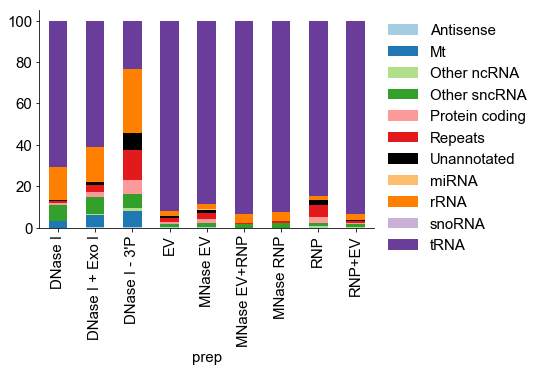

In [165]:
ax = plt.subplot()
type_df = dedup_df\
    .pipe(lambda d: d[d.prep.str.contains('DNase|EV|RNP')])\
    .groupby(['grouped_type','prep'], as_index=False)\
    .agg({'read_count':'sum'}) \
    .assign(grouped_type = lambda d: np.where(d.grouped_type=="No features",'Unannotated',d.grouped_type))\
    .assign(read_fraction = lambda d: d.groupby('prep').read_count.transform(lambda x: 100*x/x.sum()))  \
    .sort_values('prep')\
    .pipe(pd.pivot_table, index='prep', columns = 'grouped_type', values = 'read_fraction') 
colors = rna_type_ce.transform(type_df.columns).tolist()
type_df.plot.bar(stacked=True, color = colors, ax = ax)
ax.legend(bbox_to_anchor=(1,1), frameon=False, fontsize=15)
sns.despine()

In [200]:
dedup_df \
    .pipe(lambda d: d[~d.samplename.str.contains('[qQ][cC][fF][0-9]_')]) \
    .pipe(lambda d: d[d.samplename.str.contains('[qQ][cC][fF][0-9]+_')])\
    .samplename.unique()

array(['Qcf10_R1_001', 'Qcf11_R1_001', 'Qcf12_R1_001', 'Qcf13_R1_001'],
      dtype=object)

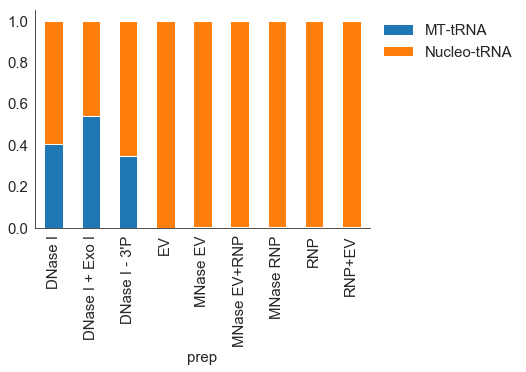

In [204]:
ax = plt.subplot()
dedup_df \
    .pipe(lambda d: d[~d.samplename.str.contains('[qQ][cC][fF][0-9]_')])\
    .pipe(lambda d: d[d.prep.str.contains('DNase|EV|RNP')]) \
    .query('grouped_type == "tRNA"')\
    .assign(is_mt = lambda d: np.where(d.gene_name.str.contains('MT'), 'MT-tRNA','Nucleo-tRNA')) \
    .groupby(['prep','is_mt'], as_index=False)\
    .agg({'read_count':'sum'}) \
    .assign(read_fraction = lambda d: d.groupby('prep').read_count.transform(lambda x: x/x.sum()))\
    .pipe(pd.pivot_table, columns = 'is_mt', index='prep', values='read_fraction')\
    .plot.bar(stacked=True, ax=ax)
ax.legend(bbox_to_anchor = (1,1), frameon=False, fontsize=15, title='')
sns.despine()

In [213]:
from sequencing_tools.viz_tools import cor_plot
from sequencing_tools.stats_tools import normalize_count

spreaded_df = dedup_df\
    .pipe(lambda d: d[d.prep.str.contains('DNase|EV|RNP')]) \
    .assign(gene_name = lambda d: d.gene_name.str.replace('-[0-9]+',''))\
    .groupby(['prep','gene_name','grouped_type'], as_index=False)\
    .agg({'read_count':'sum'})\
    .pipe(pd.pivot_table, columns = 'prep', values = 'read_count',
         index=['gene_name','grouped_type'], fill_value = 0)  
spreaded_df.head()

,prep,DNase I,DNase I + Exo I,DNase I - 3'P,EV,MNase EV,MNase EV+RNP,MNase RNP,RNP,RNP+EV
gene_name,grouped_type,,,,,,,,,
.,No features,149258,185946,1706664,3698,8046,1412,2166,14272,2564
18S_rRNA,rRNA,1202564,560670,1419974,1756,2316,23452,32369,1984,5231
28S_rRNA,rRNA,2956836,1080233,4228863,2898,3985,39902,53001,3825,8236
5.8S_rRNA,rRNA,1160434,346578,500893,3004,4516,54801,70419,4826,6675
5S_rRNA,rRNA,720550,284193,227442,1847,2623,24533,38613,2485,3712


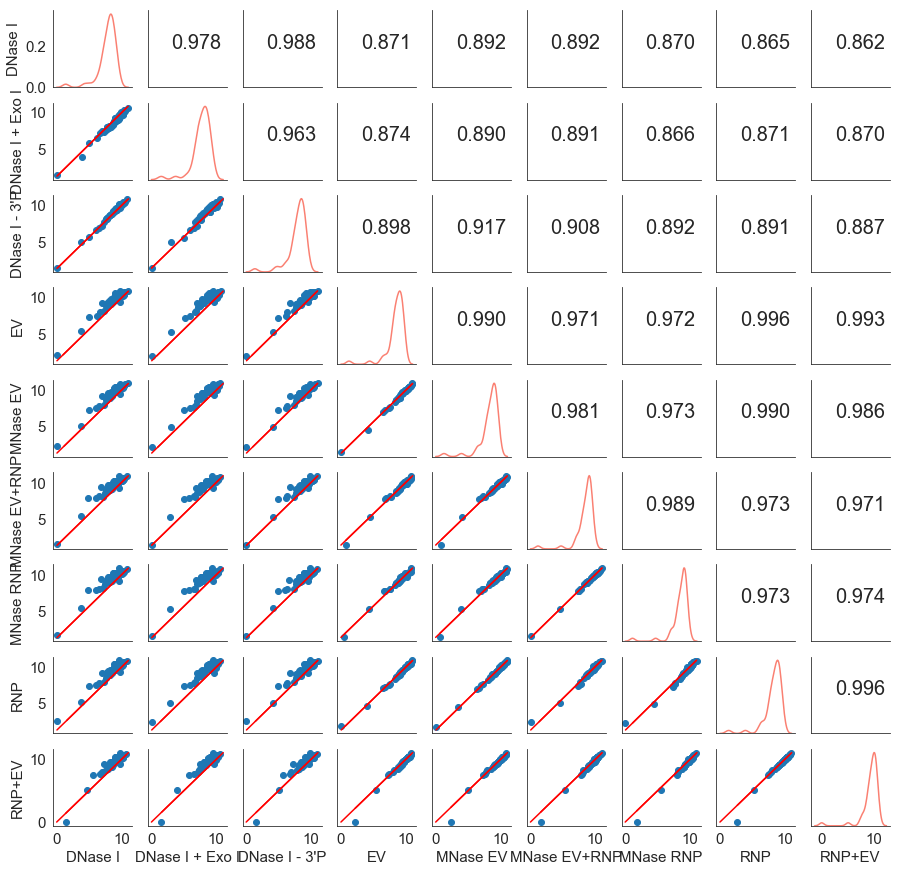

In [214]:
fig = plt.figure(figsize=(15,15))
spreaded_df\
    .reset_index()\
    .query('grouped_type == "tRNA"')\
    .drop('grouped_type', axis=1)\
    .set_index('gene_name')\
    .transform(lambda x: x/x.sum(axis=0)*1e6)\
    .transform(lambda x: np.log(x+1)) \
    .reset_index()\
    .pipe(lambda d: d[~d.gene_name.str.contains('^MT')])\
    .drop(['gene_name'], axis=1) \
    .pipe(cor_plot, fig, method = 'spearman')


Text(0.1,0.86,"Pearson's $\\rho$")

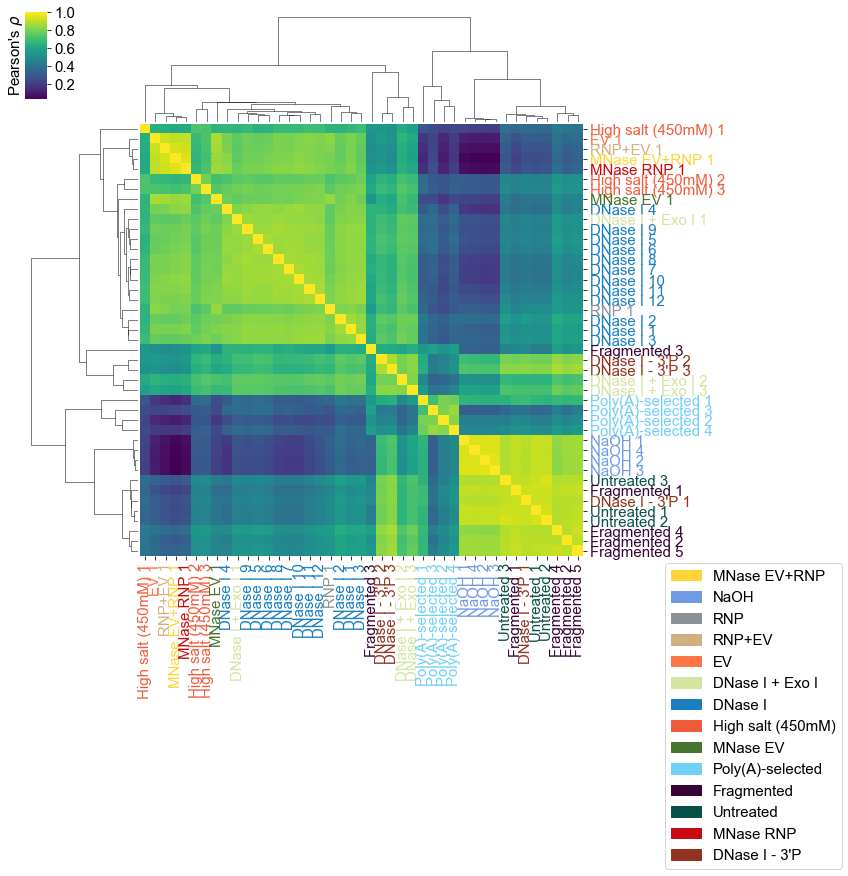

In [7]:
from collections import defaultdict
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')
cor_df = np.log(dedup_df\
                .filter(regex = 'Qcf|QCF|PP|MP')\
                .filter(regex="dedup:sense") \
                .pipe(lambda d: d[d.columns[~d.columns.str.contains('LE[0-9]+')]])\
                .pipe(lambda d: d+1))
cor_df.columns = rename_sample(cor_df.columns)
cor_df = cor_df.corr(method='pearson')
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.str.replace(' [0-9]+$',''), 
                 simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.6,0.), fontsize=15)
p.fig.text(0.1, 0.86, r"Pearson's $\rho$", rotation = 90, fontsize=15)

In [116]:
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')


filter_feature = 'No features' 
dedup_regex = ':dedup:' 
norm_df = dedup_df \
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains('Y-RNA'), 'Other sncRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains("vaultRNA|VT|vt"),'Vault RNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-'),'Mt',d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.grouped_type.isin(['rRNA','tRNA','snoRNA','snRNA','Other sncRNA','MT'])])\
        .groupby(['gene_id','gene_name','gene_type','grouped_type'])\
        .sum()\
        .pipe(lambda d: d[d.columns[d.columns.str.contains(dedup_regex)]]) \
        .filter(regex='[Qq][cC][fF][0-9]+|[Pp]hos')\
        .pipe(normalize_count)\
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_id','gene_name','gene_type','grouped_type'], 
              var_name = 'samplename', value_name = 'norm_count') 
norm_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:357: RuntimeWarning: divide by zero encountered in log
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/numpy/lib/shape_base.py:380: RuntimeWarning: divide by zero encountered in log
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


,gene_id,gene_name,gene_type,grouped_type,samplename,norm_count
0,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,QCF1_R1_001:dedup:sense,67683.410211
1,28S_rRNA,28S_rRNA,28S_rRNA,rRNA,QCF1_R1_001:dedup:sense,150076.324185
2,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,rRNA,QCF1_R1_001:dedup:sense,42393.758079
3,5S_rRNA,5S_rRNA,5S_rRNA,rRNA,QCF1_R1_001:dedup:sense,46471.829873
4,ENSG00000194270.1,Y_RNA,misc_RNA,Other sncRNA,QCF1_R1_001:dedup:sense,0.000000


In [117]:
rRNA_df = norm_df.query('grouped_type =="rRNA"') \
    .assign(prep = lambda d: d.samplename.map(label_sample)) \
    .reset_index(drop=True) 
rRNA_df.head()

,gene_id,gene_name,gene_type,grouped_type,samplename,norm_count,prep
0,18S_rRNA,18S_rRNA,18S_rRNA,rRNA,QCF1_R1_001:dedup:sense,67683.410211,DNase I
1,28S_rRNA,28S_rRNA,28S_rRNA,rRNA,QCF1_R1_001:dedup:sense,150076.324185,DNase I
2,5.8S_rRNA,5.8S_rRNA,5.8S_rRNA,rRNA,QCF1_R1_001:dedup:sense,42393.758079,DNase I
3,5S_rRNA,5S_rRNA,5S_rRNA,rRNA,QCF1_R1_001:dedup:sense,46471.829873,DNase I
4,ENSG00000199334.1,RNA5S11,rRNA,rRNA,QCF1_R1_001:dedup:sense,0.000000,DNase I


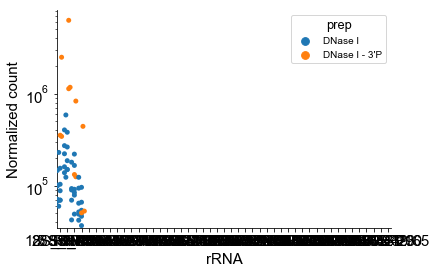

In [118]:
ax = plt.subplot(111)
sns.swarmplot(data = rRNA_df, 
              x = 'gene_name', 
              y = 'norm_count',
              dodge=True,
              hue='prep', ax =ax)
ax.set_yscale('log')
ax.set_ylabel('Normalized count')
ax.set_xlabel('rRNA')
sns.despine()

In [119]:
norm_df = dedup_df \
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains('Y-RNA'), 'Other sncRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains("vaultRNA|VT|vt"),'Vault RNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-'),'Mt',d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.gene_name.str.contains('^MT-T'),'Mt-tRNA',d.grouped_type))\
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.grouped_type.isin(['rRNA','tRNA','snoRNA','snRNA','Other sncRNA','Mt','Mt-tRNA'])])\
        .groupby(['gene_name','gene_type','grouped_type'])\
        .sum()\
        .pipe(lambda d: d[d.columns[d.columns.str.contains(dedup_regex)]]) \
        .filter(regex='[Qq][cC][fF][0-9]+|[Pp]hos|^[MP]P')\
        .reset_index()\
        .pipe(pd.melt, id_vars = ['gene_name','gene_type','grouped_type'], 
              var_name = 'samplename', value_name = 'norm_count') \
        .assign(prep = lambda d: d.samplename.map(label_sample)) 
norm_df.head()

,gene_name,gene_type,grouped_type,samplename,norm_count,prep
0,18S_rRNA,18S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,5122,RNP+EV
1,28S_rRNA,28S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,7910,RNP+EV
2,5.8S_rRNA,5.8S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,6671,RNP+EV
3,5S_rRNA,5S_rRNA,rRNA,MPCEV_R1_001:dedup:sense,3709,RNP+EV
4,5S_rRNA,rRNA,rRNA,MPCEV_R1_001:dedup:sense,0,RNP+EV


In [110]:
norm_plot_df = norm_df \
    .groupby(['grouped_type','samplename'], as_index=False)\
    .agg({'norm_count':'sum'}) \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(cpm = lambda d: d.groupby('samplename').norm_count.transform(lambda x: 1e6*x/x.sum()))
norm_plot_df.head()

,grouped_type,samplename,norm_count,prep,cpm
0,Mt,MPCEV_R1_001:dedup:sense,155,RNP+EV,200.443044
1,Mt,MPF10_R1_001:dedup:sense,452,RNP,838.299143
2,Mt,MPF4_R1_001:dedup:sense,68,EV,173.352640
3,Mt,PPCEV_R1_001:dedup:sense,2389,MNase EV+RNP,713.998160
4,Mt,PPF10_R1_001:dedup:sense,3612,MNase RNP,863.177108


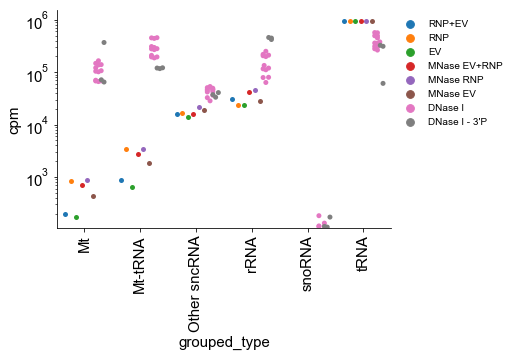

In [111]:
ax = plt.subplot(111)
sns.swarmplot(data=norm_plot_df, hue ='prep', 
              x = 'grouped_type', y ='cpm',
             dodge=True)
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,1), frameon=False)
sns.despine()
xts = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [130]:
pi_df = norm_df\
    .groupby(['gene_type','prep','samplename'], as_index=False)\
    .agg({'norm_count':'sum'})\
    .assign(norm_fraction = lambda d: d.groupby(['prep','samplename']).norm_count.transform(lambda x: 100*x/x.sum())) \
    .query('gene_type == "piRNA"')
pi_df.head()

,gene_type,prep,samplename,norm_count,norm_fraction
210,piRNA,DNase I,QCF1_R1_001:dedup:sense,51209,1.434983
211,piRNA,DNase I,QCF2_R1_001:dedup:sense,66845,1.619865
212,piRNA,DNase I,Qcf10_R1_001:dedup:sense,114239,3.594796
213,piRNA,DNase I,Qcf11_R1_001:dedup:sense,173820,3.121070
214,piRNA,DNase I,Qcf12_R1_001:dedup:sense,79088,1.647961


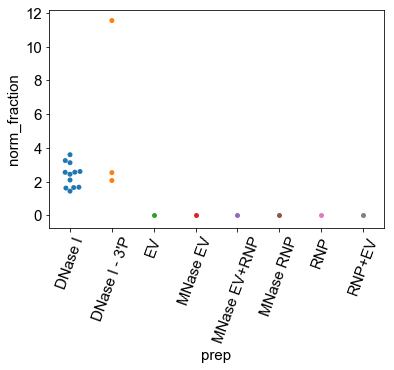

In [133]:
ax = plt.subplot()
sns.swarmplot(data = pi_df, x = 'prep',y = 'norm_fraction', ax=ax)
xt = ax.set_xticklabels(ax.get_xticklabels(), rotation=70)

In [140]:
x = pi_df.query('prep=="DNase I"').norm_fraction.tolist()
y = pi_df.query('prep=="DNase I - 3\'P"').norm_fraction.tolist()
from scipy.stats import ranksums

ranksums(x,y)

RanksumsResult(statistic=-0.5773502691896258, pvalue=0.5637028616507731)

In [139]:
dedup_df                .filter(regex = 'Qcf|QCF|PP|MP')\
                .filter(regex="dedup:sense") \
                .pipe(lambda d: d[d.columns[~d.columns.str.contains('LE[0-9]+')]])\
                .pipe(lambda d: d+1))

[1.434983283421318, 1.6198651764246308, 3.5947964362618197, 3.1210704937816502, 1.6479608963517027, 1.6700716850832549, 2.4392852876492706, 2.5587086971573645, 3.2479878319285125, 2.0953343430105003, 2.6006187331820376, 2.5516041405653516] []
